# 1) Recherche du Meilleur Modèle pour les données de plant_growth_data

## 1.1 Chargement des packages et des données

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, roc_curve, confusion_matrix,f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import joblib


In [13]:
# Charger les données
df = pd.read_csv("../data/plant_growth_data.csv", sep=";")

# Supprimer la colonne 'Fertilizer_Type'
df.drop(columns=["Fertilizer_Type"], inplace=True)

# Convertir les variables catégorielles en numériques
df = pd.get_dummies(df, columns=["Soil_Type", "Water_Frequency"])
df["Growth_Milestone"] = df["Growth_Milestone"].astype(int)

X = df.drop(columns=["Growth_Milestone"])
y = df["Growth_Milestone"]

df.head()

,Sunlight_Hours,Temperature,Humidity,Growth_Milestone,Soil_Type_clay,Soil_Type_loam,Soil_Type_sandy,Water_Frequency_bi-weekly,Water_Frequency_daily,Water_Frequency_weekly
0,5.192294,31.719602,61.591861,0,False,True,False,True,False,False
1,4.033133,28.919484,52.422276,1,False,False,True,False,False,True
2,8.892769,23.179059,44.660539,0,False,True,False,True,False,False
3,8.241144,18.465886,46.433227,0,False,True,False,True,False,False
4,8.374043,18.128741,63.625923,0,False,False,True,True,False,False


In [14]:
#Déséquilibre des classes
df["Growth_Milestone"].value_counts()

Growth_Milestone
0    97
1    96
Name: count, dtype: int64

In [24]:
df.describe()

,Sunlight_Hours,Temperature,Humidity,Growth_Milestone
count,193.000000,193.000000,193.000000,193.000000
mean,6.826484,25.076087,58.098927,0.497409
std,1.599509,5.354170,12.631799,0.501294
min,4.033133,15.200000,30.567682,0.000000
25%,5.477000,20.637095,49.300000,0.000000
50%,6.833290,25.912336,59.182806,0.000000
75%,8.241144,29.757938,69.100000,1.000000
max,9.913903,34.810103,79.648240,1.000000


## 1.2 Model

In [15]:
# Définir la validation croisée (Stratified K-Fold pour gérer les déséquilibres de classe)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 1. Régression Logistique avec K-Fold
log_reg = LogisticRegression(max_iter=1000)

# Initialiser une liste pour stocker les prédictions
log_reg_preds = []

# Effectuer l'entraînement avec K-Fold
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    log_reg.fit(X_train, y_train)  # Entraîner sur les données d'entraînement
    log_reg_preds.extend(log_reg.predict(X_val))  # Prédictions sur les données de validation

# 2. Random Forest avec K-Fold
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialiser une liste pour stocker les prédictions
rf_preds = []

# Effectuer l'entraînement avec K-Fold
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    rf.fit(X_train, y_train)  # Entraîner sur les données d'entraînement
    rf_preds.extend(rf.predict(X_val))  # Prédictions sur les données de validation

# 3. SVM avec K-Fold
svm = SVC(kernel='rbf', probability=True, random_state=42)

# Initialiser une liste pour stocker les prédictions
svm_preds = []

# Effectuer l'entraînement avec K-Fold
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    svm.fit(X_train, y_train)  # Entraîner sur les données d'entraînement
    svm_preds.extend(svm.predict(X_val))  # Prédictions sur les données de validation

## 1.3 Métriques

In [ ]:
# Calcul des métriques : accuracy
log_reg_accuracy = accuracy_score(y, log_reg_preds)
rf_accuracy = accuracy_score(y, rf_preds)
svm_accuracy = accuracy_score(y, svm_preds)

# Calcul des AUC (on récupère les probabilités pour les calculer)
log_reg_prob = log_reg.predict_proba(X)[:, 1]
rf_prob = rf.predict_proba(X)[:, 1]
svm_prob = svm.predict_proba(X)[:, 1]

log_reg_auc = roc_auc_score(y, log_reg_prob)
rf_auc = roc_auc_score(y, rf_prob)
svm_auc = roc_auc_score(y, svm_prob)

# Afficher les résultats
print("Régression Logistique - Accuracy:", log_reg_accuracy)
print("Régression Logistique - AUC:", log_reg_auc)

print("Random Forest - Accuracy:", rf_accuracy)
print("Random Forest - AUC:", rf_auc)

print("SVM - Accuracy:", svm_accuracy)
print("SVM - AUC:", svm_auc)

# print(log_reg_prob)
# print(rf_prob)
# print(svm_prob)

# Affichage des matrices de confusion
print("Matrice de confusion - Régression Logistique :")
print(confusion_matrix(y, log_reg_preds))

print("Matrice de confusion - Random Forest :")
print(confusion_matrix(y, rf_preds))

print("Matrice de confusion - SVM :")
print(confusion_matrix(y, svm_preds))

log_reg_f1 = f1_score(y, log_reg_preds)
rf_f1 = f1_score(y, rf_preds)
svm_f1 = f1_score(y, svm_preds)

print("Régression Logistique - F1-score:", log_reg_f1)
print("Random Forest - F1-score:", rf_f1)
print("SVM - F1-score:", svm_f1)

Régression Logistique - Accuracy: 0.46632124352331605
Régression Logistique - AUC: 0.6157646048109965
Random Forest - Accuracy: 0.5233160621761658
Random Forest - AUC: 0.9806701030927836
SVM - Accuracy: 0.49740932642487046
SVM - AUC: 0.5807560137457044
Matrice de confusion - Régression Logistique :
[[48 49]
 [54 42]]
Matrice de confusion - Random Forest :
[[54 43]
 [49 47]]
Matrice de confusion - SVM :
[[34 63]
 [34 62]]
Régression Logistique - F1-score: 0.44919786096256686
Random Forest - F1-score: 0.5053763440860215
SVM - F1-score: 0.5610859728506787


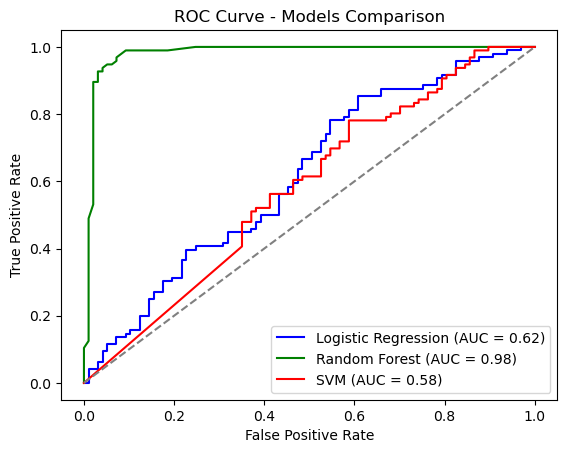

In [7]:
# Courbes ROC
fpr_logreg, tpr_logreg, _ = roc_curve(y, log_reg_prob)
fpr_rf, tpr_rf, _ = roc_curve(y, rf_prob)
fpr_svm, tpr_svm, _ = roc_curve(y, svm_prob)

# Tracer la courbe ROC
plt.figure()
plt.plot(fpr_logreg, tpr_logreg, color='blue', label=f'Logistic Regression (AUC = {log_reg_auc:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(fpr_svm, tpr_svm, color='red', label=f'SVM (AUC = {svm_auc:.2f})')

plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Models Comparison')
plt.legend(loc='lower right')
plt.show()

# 2) RandomForest

## 2.1 GridSearch

In [8]:
# Définir la grille des hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100, 200],  # Nombre d'arbres dans le Random Forest
    'max_depth': [None, 10, 20, 30],  # Profondeur maximale des arbres
    'min_samples_split': [2, 5, 10],  # Nombre minimum d'échantillons pour diviser un noeud
    'min_samples_leaf': [1, 2, 4],    # Nombre minimum d'échantillons dans une feuille
    'max_features': ['sqrt', 'log2'],  # Nombre de caractéristiques à considérer pour la meilleure division
    'bootstrap': [True, False]  # Utilisation du bootstrap pour la construction des arbres
}

# Initialiser le RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Créer le GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, scoring='accuracy', verbose=2)

# Lancer le GridSearchCV
grid_search.fit(X, y)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=2)

In [23]:
# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres trouvés :", grid_search.best_params_)

# Utiliser le meilleur modèle trouvé pour faire des prédictions
best_rf = grid_search.best_estimator_

# Prédictions
rf_pred = best_rf.predict(X)

# Calculer l'accuracy et l'AUC
accuracy = accuracy_score(y, rf_pred)
auc = roc_auc_score(y, best_rf.predict_proba(X)[:, 1])

print("Accuracy du Random Forest optimisé : {:.4f}".format(accuracy))
print("AUC du Random Forest optimisé : {:.4f}".format(auc))

# Matrice de confusion
conf_matrix = confusion_matrix(y, rf_pred)
print("Matrice de confusion :\n", conf_matrix)


rf_f1 = f1_score(y, rf_pred)
print("Random Forest - F1-score:", rf_f1)

Meilleurs paramètres trouvés : {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Accuracy du Random Forest optimisé : 0.9741
AUC du Random Forest optimisé : 0.9974
Matrice de confusion :
 [[94  3]
 [ 2 94]]
Random Forest - F1-score: 0.9740932642487047


## 2.2 Sauvegarde du model

In [12]:
# Enregistrer le meilleur modèle trouvé par GridSearchCV
joblib.dump(grid_search.best_estimator_, "../data/random_forest_model_plant_growth.pkl")

['../data/random_forest_model_plant_growth.pkl']

## 2.3 Meilleurs paramètres

                     Feature  Importance
2                   Humidity    0.350783
1                Temperature    0.287086
0             Sunlight_Hours    0.241738
7      Water_Frequency_daily    0.028364
4             Soil_Type_loam    0.024152
3             Soil_Type_clay    0.021282
6  Water_Frequency_bi-weekly    0.017839
8     Water_Frequency_weekly    0.016214
5            Soil_Type_sandy    0.012541


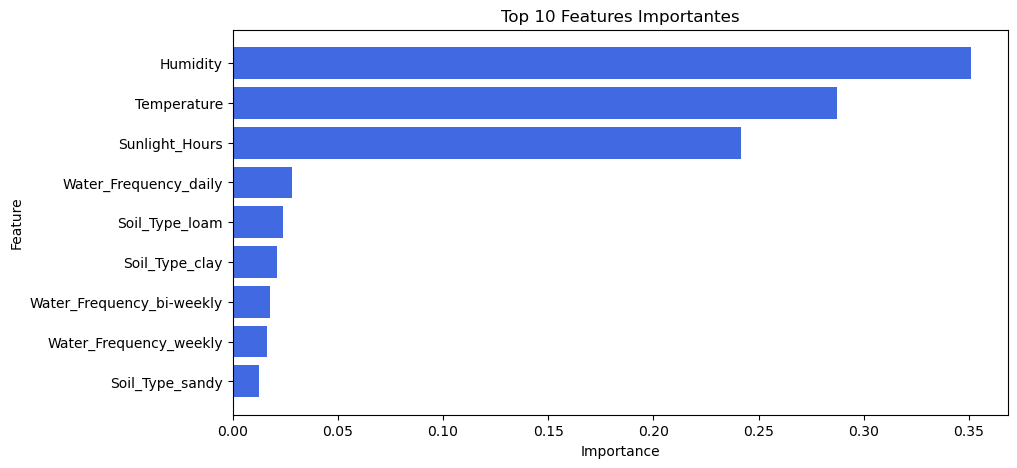

In [10]:
# Récupérer l'importance des features du meilleur modèle
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
})

# Trier par importance décroissante
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Afficher les 10 variables les plus importantes
print(feature_importances.head(10))

# Visualisation
plt.figure(figsize=(10, 5))
plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10], color='royalblue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Features Importantes")
plt.gca().invert_yaxis()
plt.show()